Ref: 
(https://www.kaggle.com/code/ambrosm/tpsaug22-eda-which-makes-sense)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from colorama import Fore, Back, Style
import scipy.stats

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, roc_curve

from lightgbm import LGBMClassifier, early_stopping, log_evaluation

np.set_printoptions(linewidth=150)

## Data Loading

In [2]:
train = pd.read_csv('../data/01_raw/tabular-playground-series-aug-2022/train.csv',
                    index_col='id')
test = pd.read_csv('../data/01_raw/tabular-playground-series-aug-2022/test.csv',
                    index_col='id')
display(train)
display(test)
both = pd.concat([train[test.columns], test])

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,E,158.95,material_7,material_6,6,9,6,16,4,16.301,...,NaN,12.177,17.942,10.112,15.795,18.572,16.144,NaN,729.131,0
26566,E,146.02,material_7,material_6,6,9,10,12,8,17.543,...,11.242,14.179,20.564,10.234,14.450,14.322,13.146,16.471,853.924,0
26567,E,115.62,material_7,material_6,6,9,1,10,1,15.670,...,11.407,16.437,17.476,8.668,15.069,16.599,15.590,14.065,750.364,0


,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
id,,,,,,,,,,,,,,,,,,,,,
26570,F,119.57,material_5,material_6,6,4,6,9,6,19.305,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
26571,F,113.51,material_5,material_6,6,4,11,8,0,17.883,...,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
26572,F,112.16,material_5,material_6,6,4,8,12,4,18.475,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
26573,F,112.72,material_5,material_6,6,4,8,11,10,16.518,...,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
26574,F,208.00,material_5,material_6,6,4,14,16,8,17.808,...,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47340,I,144.74,material_7,material_5,9,5,0,4,9,18.465,...,18.573,11.691,NaN,19.771,11.562,17.246,15.131,15.209,NaN,696.466
47341,I,74.53,material_7,material_5,9,5,4,8,7,18.900,...,17.917,10.980,16.027,15.694,13.564,15.494,15.296,13.812,16.501,613.249
47342,I,67.73,material_7,material_5,9,5,10,11,2,18.656,...,19.630,10.436,16.137,20.612,11.134,16.519,15.525,14.175,17.728,783.349


Of the 26,570 from Train set, only 21 percent failed. 

<b>Insights</b>: This looks slightly imbalanced. Might be good to stratify train-test split.

In [3]:
train.failure.value_counts() / len(train)

0    0.787392
1    0.212608
Name: failure, dtype: float64

In [4]:
# Check missing value 
mis_train = train.isna().sum().to_frame()#.reset_index()
mis_test = test.isna().sum().to_frame()
mis_train.columns, mis_test.columns = ['train_cols'], ['test_cols']
missing_cols = pd.concat([mis_train, mis_test], axis=1)
missing_cols

,train_cols,test_cols
product_code,0,0.0
loading,250,223.0
attribute_0,0,0.0
attribute_1,0,0.0
attribute_2,0,0.0
attribute_3,0,0.0
measurement_0,0,0.0
measurement_1,0,0.0
measurement_2,0,0.0
measurement_3,381,329.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26570 entries, 0 to 26569
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_code    26570 non-null  object 
 1   loading         26320 non-null  float64
 2   attribute_0     26570 non-null  object 
 3   attribute_1     26570 non-null  object 
 4   attribute_2     26570 non-null  int64  
 5   attribute_3     26570 non-null  int64  
 6   measurement_0   26570 non-null  int64  
 7   measurement_1   26570 non-null  int64  
 8   measurement_2   26570 non-null  int64  
 9   measurement_3   26189 non-null  float64
 10  measurement_4   26032 non-null  float64
 11  measurement_5   25894 non-null  float64
 12  measurement_6   25774 non-null  float64
 13  measurement_7   25633 non-null  float64
 14  measurement_8   25522 non-null  float64
 15  measurement_9   25343 non-null  float64
 16  measurement_10  25270 non-null  float64
 17  measurement_11  25102 non-null 

### Float columns

In [6]:
# float columns.
float_cols = [f for f in train.columns if train[f].dtype == float]

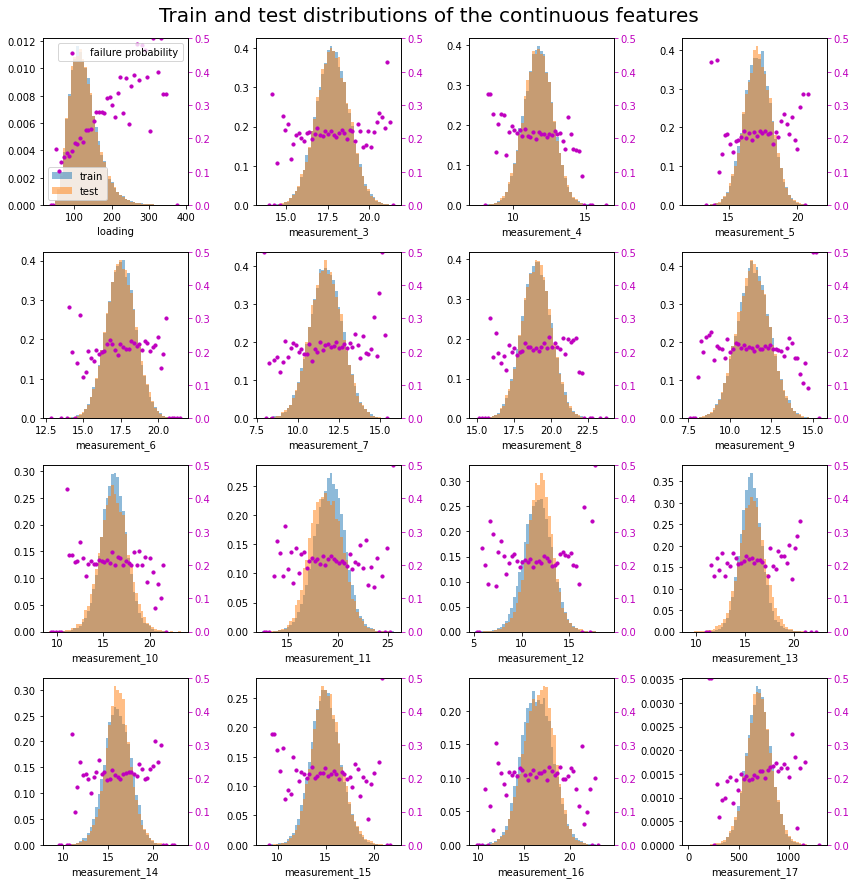

In [7]:
_, axs = plt.subplots(4, 4, figsize=(12,12))
for f, ax in zip(float_cols, axs.ravel()):
    mi = min(train[f].min(), test[f].min())
    ma = max(train[f].max(), test[f].max())
    bins = np.linspace(mi, ma, 50)
    ax.hist(train[f], bins=bins, alpha=0.5, density=True, label='train')
    ax.hist(test[f], bins=bins, alpha=0.5, density=True, label='test')
    ax.set_xlabel(f)
    if ax == axs[0, 0]: ax.legend(loc='lower left')
        
    ax2 = ax.twinx()
    total, _ = np.histogram(train[f], bins=bins)
    failures, _ = np.histogram(train[f][train.failure == 1], bins=bins)
    with warnings.catch_warnings(): # ignore divide by zero for empty bins
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        ax2.scatter((bins[1:] + bins[:-1]) / 2, failures / total,
                    color='m', s=10, label='failure probability')
    ax2.set_ylim(0, 0.5)
    ax2.tick_params(axis='y', colors='m')
    if ax == axs[0, 0]: ax2.legend(loc='upper right')
plt.tight_layout(w_pad=1)
plt.suptitle('Train and test distributions of the continuous features', fontsize=20, y=1.02)
plt.show()

Insight: With that many missing values, good value imputation will be the key for winning the competition.

Let's look at the distribution of the float features. We plot the train and test histograms in the same diagram - train is blue, test is orange.

We see that the first feature, loading, has a skewed distribution, perhaps log-normal; the other features are normally distributed. The first eight features have the same distribution in train and test; from measurement_10 onwards the distributions differ slightly.

In the same diagrams, we show the failure probabilities with magenta dots. The top left diagram shows that higher loadings imply a higher failure probability. The bottom right diagram shows that measurement_17 is positively correlated to the target as well. All other float features seem to be uncorrelated to the failure probability (the failure probability is 21 % independent of the feature value).

#### Binomial distribution -> test for failure count.

Maybe the cause of a product failure triggers the failure of a measurement device. How can we test this idea? We calculate the conditional product failure rate given the measurement is missing E[product fails | measurement is missing] and compare it to the unconditional product failure rate, which is 0.212608.

feature           fail   miss   failure rate       z    p-value
loading         :   44 /  250 = 0.176          -1.41      0.157
measurement_3   :   61 /  381 = 0.160          -2.50      0.012
measurement_4   :  128 /  538 = 0.238           1.43      0.151
measurement_5   :  172 /  676 = 0.254           2.66      0.008
measurement_6   :  171 /  796 = 0.215           0.15      0.879
measurement_7   :  197 /  937 = 0.210          -0.18      0.860
measurement_8   :  218 / 1048 = 0.208          -0.36      0.716
measurement_9   :  283 / 1227 = 0.231           1.54      0.123
measurement_10  :  277 / 1300 = 0.213           0.04      0.967
measurement_11  :  311 / 1468 = 0.212          -0.07      0.944
measurement_12  :  356 / 1601 = 0.222           0.95      0.340
measurement_13  :  373 / 1774 = 0.210          -0.24      0.809
measurement_14  :  413 / 1874 = 0.220           0.82      0.411
measurement_15  :  430 / 2009 = 0.214           0.16      0.876
measurement_16  :  436 / 2110 = 0.207   

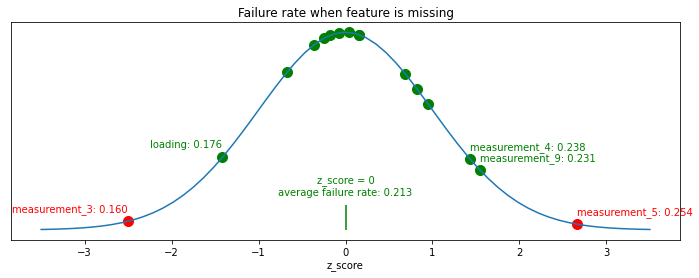

In [8]:
# Start by plotting the bell curve
plt.figure(figsize=(12, 4))
z_ticks = np.linspace(-3.5, 3.5, 61)
pdf = scipy.stats.norm.pdf(z_ticks)
plt.plot(z_ticks, pdf)
# Calculate the conditional failure rate for every missing feature
# Print the values and plot them
print('feature           fail   miss   failure rate       z    p-value')
for f in train.columns:
    if train[f].isna().sum() > 0:
        total = train[f].isna().sum()
        fail = train[train[f].isna()].failure.sum()
        z = (fail / total - 0.212608) / (np.sqrt(0.212608 * (1-0.212608)) / np.sqrt(total))
        plt.scatter([z], [scipy.stats.norm.pdf(z)], c='r' if abs(z) > 2 else 'g', s=100)
        print(f"{f:15} : {fail:4} / {total:4} = {fail/total:.3f}          {z:5.2f}      {2*scipy.stats.norm.cdf(-abs(z)):.3f}")
        if abs(z) > 1: plt.annotate(f"{f}: {fail / total:.3f}",
                                    (z, scipy.stats.norm.pdf(z)),
                                    xytext=(0,10), 
                                    textcoords='offset points', ha='left' if z > 0 else 'right',
                                    color='r' if abs(z) > 2 else 'g')
            
# Annotage the center (z=0)
plt.vlines([0], 0, 0.05, color='g')
plt.annotate(f"z_score = 0\naverage failure rate: {0.212608:.3f}",
                                    (0, 0.05),
                                    xytext=(0,10), 
                                    textcoords='offset points', ha='center',
                                    color='g')
plt.title('Failure rate when feature is missing')
plt.yticks([])
plt.xlabel('z_score')
plt.show()

When measurement_3 is missing, the failure rate is 0.160 (much lower than average).
When measurement_5 is missing, the failure rate is 0.254 (much higher than average).

### Integer columns

In [9]:
int_cols = [f for f in train.columns if train[f].dtype == 'int64' and f != 'failure']
pd.concat([train[int_cols].isna().sum().rename('missing_values in train'),
           test[int_cols].isna().sum().rename('missing values in test')], 
          axis=1)

,missing_values in train,missing values in test
attribute_2,0,0
attribute_3,0,0
measurement_0,0,0
measurement_1,0,0
measurement_2,0,0


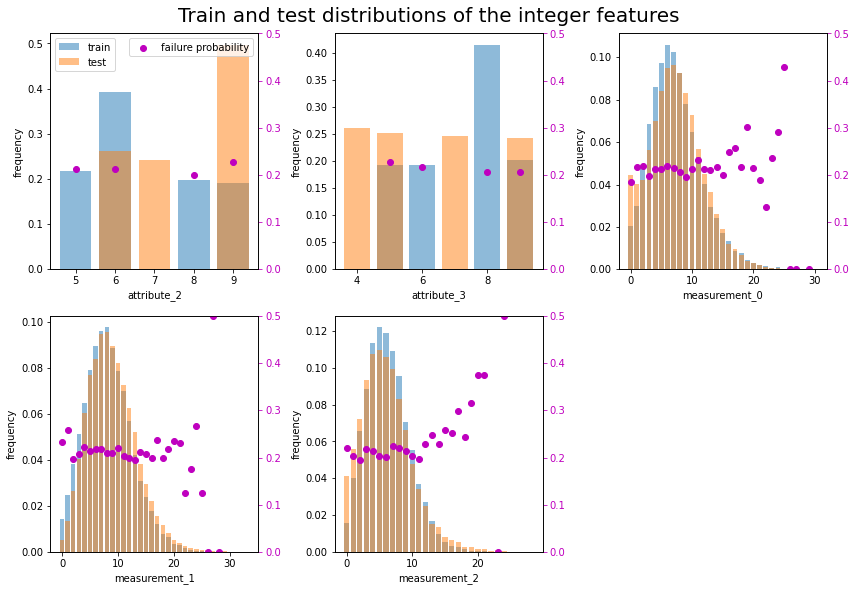

In [10]:
# Let's plot the distributions of the five integer features for train and test:
_, axs = plt.subplots(2, 3, figsize=(12, 8))
for f, ax in zip(int_cols, axs.ravel()):
    temp1 = train.failure.groupby(train[f]).agg(['mean', 'size'])
    ax.bar(temp1.index, temp1['size'] / len(train), alpha=0.5, label='train')
    temp2 = test[f].value_counts()
    ax.bar(temp2.index, temp2 / len(test), alpha=0.5, label='test')
    ax.set_xlabel(f)
    ax.set_ylabel('frequency')
    
    ax2 = ax.twinx()
    ax2.scatter(temp1.index, temp1['mean'],
                color='m', label='failure probability')
    ax2.set_ylim(0, 0.5)
    ax2.tick_params(axis='y', colors='m')
    if ax == axs[0, 0]: ax2.legend(loc='upper right')

axs[0, 0].legend()
axs[1, 2].axis('off')
plt.tight_layout(w_pad=1)
plt.suptitle('Train and test distributions of the integer features', fontsize=20, y=1.02)
plt.show()
del temp1, temp2

We can see for attribute 2 values occur only in train set, 5 and 8, while attribute 7 only exists in test set. 
attribute 3 is also similar.
Measurement_2 has positive correlation to failure (target) for values >10. 

### The string columns

In [11]:
string_cols = [f for f in train.columns if train[f].dtype == object]
pd.concat([train[string_cols].isna().sum().rename('missing values in train'),
           test[string_cols].isna().sum().rename('missing values in test')],
          axis=1) # no missing values.

,missing values in train,missing values in test
product_code,0,0
attribute_0,0,0
attribute_1,0,0


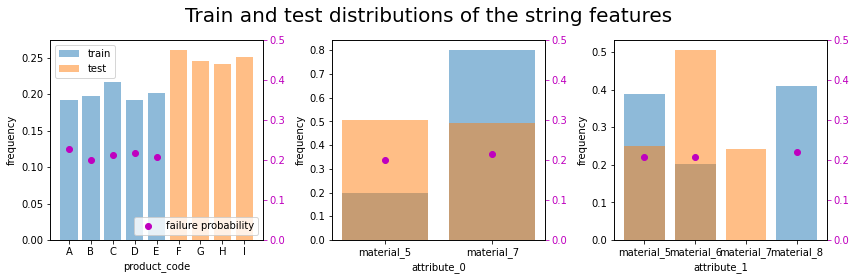

In [12]:
_, axs = plt.subplots(1, 3, figsize=(12, 4))
for f, ax in zip(string_cols, axs.ravel()):
    temp1 = train[f].value_counts(dropna=False, normalize=True)
    temp2 = test[f].value_counts(dropna=False, normalize=True)
    values = sorted(set(temp1.index).union(temp2.index))
    temp1 = temp1.reindex(values)
    temp2 = temp2.reindex(values)
    ax.bar(range(len(values)), temp1, alpha=0.5, label='train')
    ax.bar(range(len(values)), temp2, alpha=0.5, label='test')
    ax.set_xlabel(f)
    ax.set_ylabel('frequency')
    ax.set_xticks(range(len(values)), values)
    
    temp1 = train.failure.groupby(train[f]).agg(['mean', 'size'])
    temp1 = temp1.reindex(values)
    ax2 = ax.twinx()
    ax2.scatter(range(len(values)), temp1['mean'],
                color='m', label='failure probability')
    ax2.tick_params(axis='y', colors='m')
    ax2.set_ylim(0, 0.5)
    if ax == axs[0]: ax2.legend(loc='lower right')

axs[0].legend()
plt.suptitle('Train and test distributions of the string features', fontsize=20, y=0.96)
plt.tight_layout(w_pad=1)
plt.show()
del temp1, temp2  

Product codes do not overlap between train and test set. To simulate failure, we have to simulate this situation by splitting the data so that the validation set contains other products than the training set. 

Attribute_0 and attribute_1 are categorical features which should be one-hot encoded.

### Missing data analysis

<AxesSubplot:>

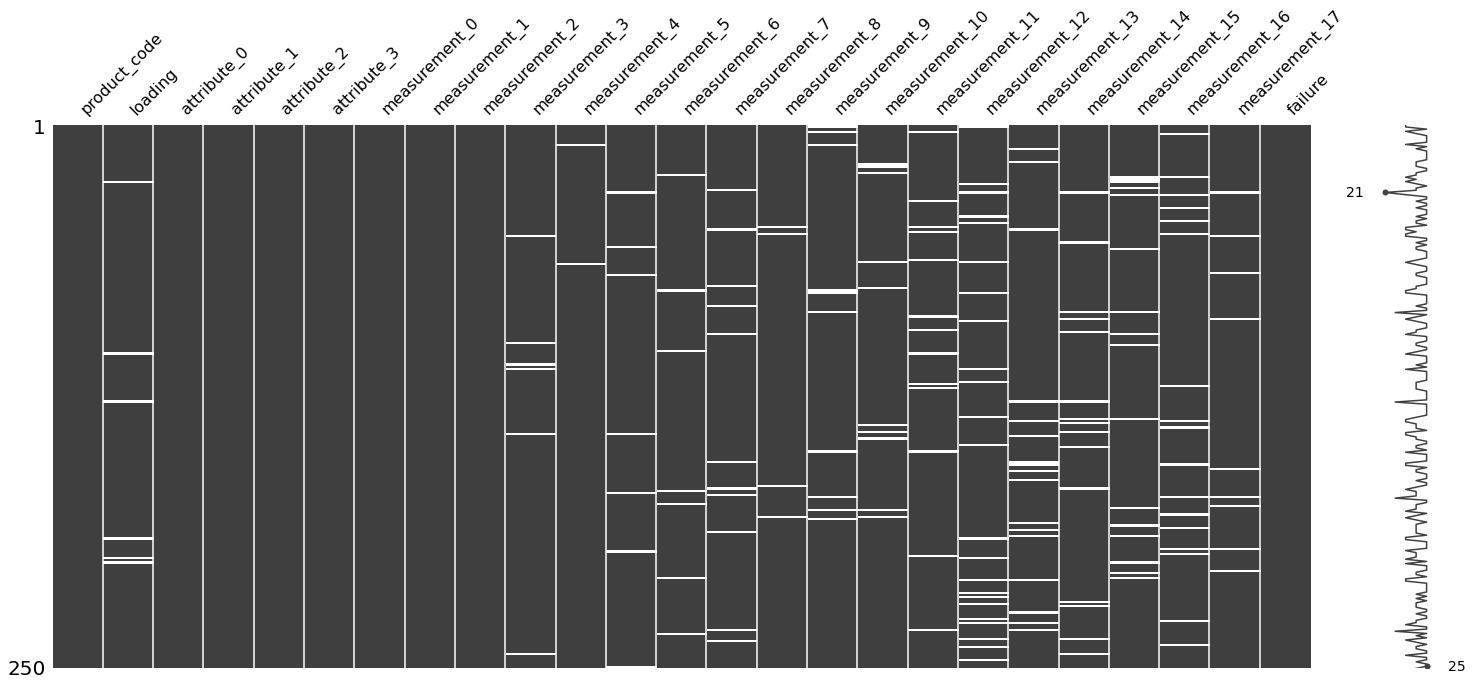

In [13]:
import missingno as msno
Nrows,Ncols = train.shape

msno.matrix(train.iloc[np.random.choice(range(Nrows), 250)])

The missingness seems similar between both the training and the test set. The product_code and the `attribute_i` features are all completely non-missing. `measurement_i`, for  i≤2  are all non-missing. `measurement_i` for  `i≥3`  have some missing values and have progressively increasing proportion of missingness. This suggests that there are a series of measurements, the results of which determine whether or not later tests are carried out. The probabilities of later measurements being missing doesn't appear to be too strongly related to the missingness of earlier measurements, as inferred from msno.heatmap (not shown here), however the dendrogram analysis from msno shows a definite pattern:

<AxesSubplot:>

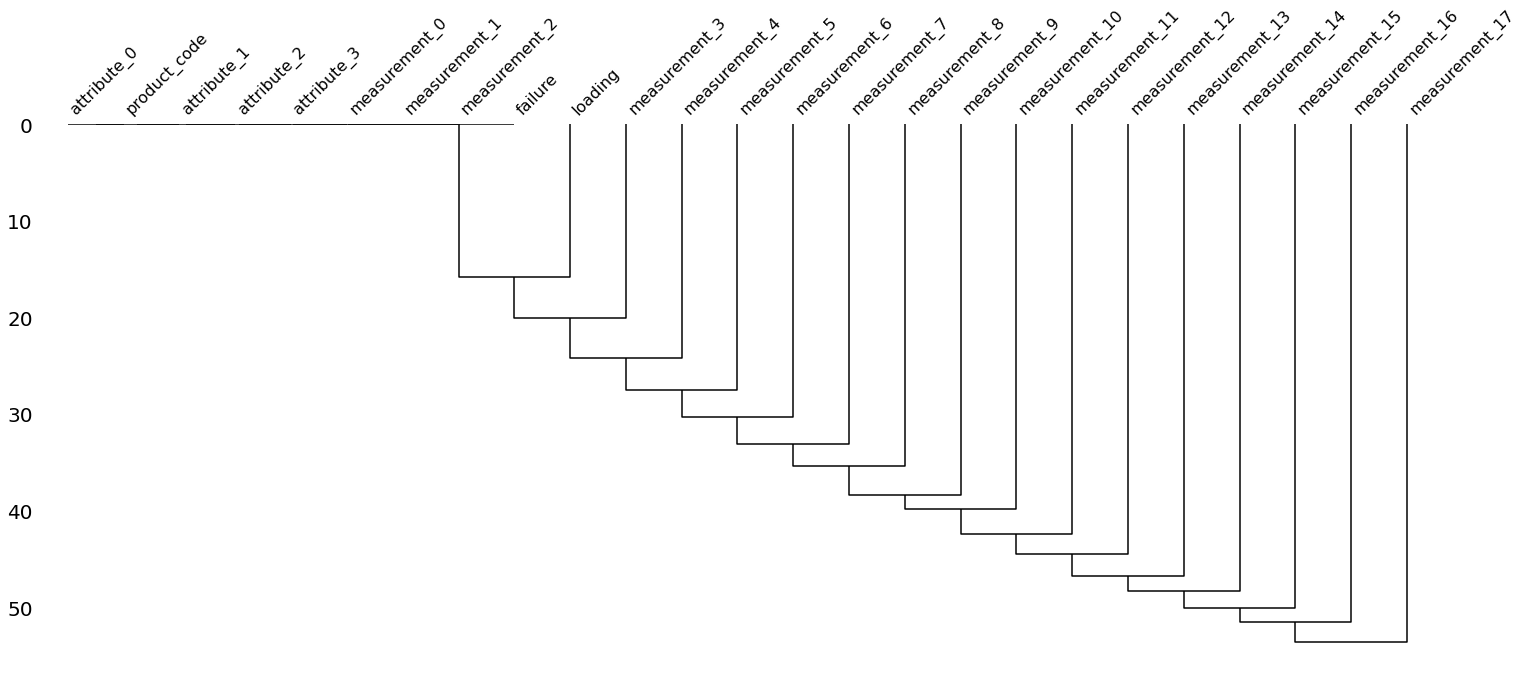

In [14]:
msno.dendrogram(train)

In [15]:
# Product codes and attributes
both[string_cols + ['attribute_2', 'attribute_3']].drop_duplicates().set_index('product_code')

,attribute_0,attribute_1,attribute_2,attribute_3
product_code,,,,
A,material_7,material_8,9,5
B,material_5,material_5,8,8
C,material_7,material_8,5,8
D,material_7,material_5,6,6
E,material_7,material_6,6,9
F,material_5,material_6,6,4
G,material_5,material_6,9,7
H,material_7,material_7,7,9
I,material_7,material_5,9,5


<iframe src="https://www.kaggle.com/embed/ambrosm/tpsaug22-eda-which-makes-sense?cellIds=28&kernelSessionId=102683452" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="TPSAUG22 EDA which makes sense ⭐️⭐️⭐️⭐️⭐️"></iframe>

In [16]:
train.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


Fold 0: auc = 0.58827
Fold 1: auc = 0.58291
Fold 2: auc = 0.59105
Fold 3: auc = 0.59753
Fold 4: auc = 0.59675
Average auc = 0.59130


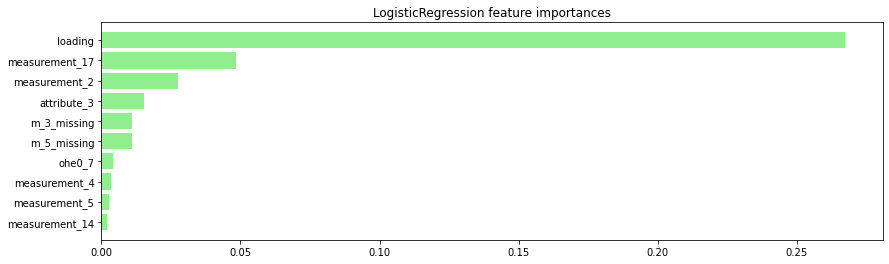

In [20]:
auc_list = []
test_pred_list = []
importance_list = []

kf = GroupKFold(n_splits=5)
for fold, (idx_tr,idx_va) in enumerate(kf.split(train, train.failure, train.product_code)):
    X_tr = train.iloc[idx_tr][test.columns]
    X_va = train.iloc[idx_va][test.columns]
    X_te = test.copy()
    y_tr = train.iloc[idx_tr].failure
    y_va = train.iloc[idx_va].failure
    
    # one-hot encode attribute_0 and attribute_1
    ohe_attributes = ['attribute_0', 'attribute_1']
    ohe_output = ['ohe0_7', 'ohe1_6', 'ohe1_8']
    ohe = OneHotEncoder(categories=[['material_5', 'material_7'],
                                    ['material_5', 'material_6', 'material_8']],
                        drop='first', sparse=False, handle_unknown='ignore')
    ohe.fit(X_tr[ohe_attributes])
    
    for df in [X_tr, X_va, X_te]:
        with warnings.catch_warnings(): # ignore "Found unknown categories"
            warnings.filterwarnings('ignore', category=UserWarning)
            df[ohe_output] = ohe.transform(df[ohe_attributes])
        df.drop(columns=ohe_attributes, inplace=True)
        
    # We add the indicators for missing values
    for df in [X_tr, X_va, X_te]:
        df['m_3_missing'] = df.measurement_3.isna()
        df['m_5_missing'] = df.measurement_5.isna()
    
    # We fill the missing values
    features = [f for f in X_tr.columns if f == 'loading' or f.startswith('measurement')]
    imputer = KNNImputer(n_neighbors=3)
    imputer.fit(X_tr[features])
    for df in [X_tr, X_va, X_te]:
        df[features] = imputer.transform(df[features])
    
    # The EDA diagram of measurement 2 shows that the feature is correlated
    # to the target only for values above 10. For this reason, we clip
    # all values below 11.
    for df in [X_tr, X_va, X_te]:
        df['measurement_2'] = df['measurement_2'].clip(11, None)
    
    # We fit a model
    features2 = [f for f in X_tr.columns if f != 'product_code']
    model = make_pipeline(StandardScaler(), 
                          LogisticRegression(penalty='l1', C=0.01,
                                             solver='liblinear', random_state=1))
    model.fit(X_tr[features2], y_tr)
    importance_list.append(model.named_steps['logisticregression'].coef_.ravel())
    
    # We validate the model
    y_va_pred = model.predict_proba(X_va[features2])[:,1]
    score = roc_auc_score(y_va, y_va_pred)
    print(f"Fold {fold}: auc = {score:.5f}")
    auc_list.append(score)
# Show overall score
print(f"{Fore.GREEN}{Style.BRIGHT}Average auc = {sum(auc_list) / len(auc_list):.5f}{Style.RESET_ALL}")

# Show feature importances
importance_df = pd.DataFrame(np.array(importance_list).T, index=features2)
importance_df['mean'] = importance_df.mean(axis=1).abs()
importance_df['feature'] = features2
importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(10)
plt.figure(figsize=(14, 4))
plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
plt.gca().invert_yaxis()
plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
plt.title('LogisticRegression feature importances')
plt.show()

In [19]:
y_tr

id
5100     0
5101     0
5102     0
5103     0
5104     0
        ..
26565    0
26566    0
26567    0
26568    0
26569    0
Name: failure, Length: 21470, dtype: int64

## Classification with keras

https://www.kaggle.com/code/heyspaceturtle/feature-selection-is-all-u-need?scriptVersionId=102667189

In [25]:
# Data Processing
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

# Modeling 
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import cluster, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_score, StratifiedKFold

# Other 
import warnings
warnings.filterwarnings('ignore')

In [31]:
# Load Data
train = pd.read_csv('../data/01_raw//tabular-playground-series-aug-2022/train.csv')
test = pd.read_csv('../data/01_raw/tabular-playground-series-aug-2022/test.csv')
sample_submission = pd.read_csv('../data/01_raw//tabular-playground-series-aug-2022/sample_submission.csv')

train.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [32]:
# Variable lists for easy manipulation
id_var = ['id']
target= ['failure']
cat_vars = ['product_code','attribute_0','attribute_1']
num_vars = [v for v in test.columns if v not in id_var and v not in cat_vars]
predictors = cat_vars + num_vars

In [33]:
# Drop product code
test = test.drop(['product_code'], axis = 1)
train = train.drop(['product_code'], axis = 1)
cat_vars.remove('product_code')

In [34]:
# feature engineering
train['attribute_2*3'] = train['attribute_2'] * train['attribute_3']
test['attribute_2*3'] = test['attribute_2'] * test['attribute_3']

train['meas17_loading_ratio'] = train['measurement_17']/train['loading']
test['meas17_loading_ratio'] = test['measurement_17']/test['loading']

meas_cols = [f"measurement_{i:d}" for i in list(range(3, 17))]
train['meas_avg'] = np.mean(train[meas_cols], axis=1)
train['meas_std'] = np.std(train[meas_cols], axis=1)
train['meas_max'] = np.max(train[meas_cols], axis=1)
train['meas_min'] = np.min(train[meas_cols], axis=1)

test['meas_avg'] = np.mean(test[meas_cols], axis=1)
test['meas_std'] = np.std(test[meas_cols], axis=1) 
test['meas_max'] = np.max(test[meas_cols], axis=1)
test['meas_min'] = np.min(test[meas_cols], axis=1)

In [35]:
# Label Encoding
label_encoder = LabelEncoder()
train_le = train.copy()
test_le = test.copy()

for col in ['attribute_0', 'attribute_1']:
    train_le[col] = label_encoder.fit_transform(train[col])
    test_le[col] = label_encoder.fit_transform(test[col]) 
        
train = train_le
test = test_le

In [36]:
# update predictor list
predictors = [v for v in train.columns if v not in id_var and v not in target]
train.shape

(26570, 31)

### Feature selection with Fischer's score

In [37]:
def FisherScore(bt, y_train, predictors):
    """
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    # Get the unique values of dependent variable
    target_var_val = y_train.unique()
    
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[y_train == target_var_val[0], v]) - np.mean(bt.loc[y_train == target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[y_train == target_var_val[0], v]) + np.var(bt.loc[y_train == target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

In [39]:
# Calculate Fisher Score for all variables
fs = FisherScore(train, train['failure'], predictors)
fs_df = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_df = fs_df.sort_values('fisherscore', ascending=False).round(3)
fs_df.head()

,predictor,fisherscore
0,loading,0.218
24,meas17_loading_ratio,0.149
22,measurement_17,0.059
4,attribute_3,0.033
10,measurement_5,0.031


In [40]:
# visualise FS head.


## Data Cleaning

(https://www.kaggle.com/code/nnjjpp/adversarial-validation-detecting-data-drift)

In [17]:
os.getcwd()

'd:\\1. Data Science\\6. Machine Learning\\2.Supervised ML\\tps\\notebooks'

In [25]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

sample = pd.read_csv('../data/01_raw/tabular-playground-series-aug-2022/sample_submission.csv')
train = pd.read_csv('../data/01_raw/tabular-playground-series-aug-2022/train.csv')
test = pd.read_csv('../data/01_raw/tabular-playground-series-aug-2022/test.csv')

In [26]:
# These modifications to the preprocessing steps allow for variable names to 
# be preserved, which is useful/needed when plotting variable importance

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
class SimpleImputerNamed(SimpleImputer):
    def get_feature_names_out(self):
        return list(self.feature_names_in_)
class OrdinalEncoderNamed(OrdinalEncoder):
    def get_feature_names_out(self):
        return list(self.feature_names_in_)
class ColumnTransformerNamed(ColumnTransformer):
    def get_feature_names_out(self):
        names = []
        for transformer in self.transformers_:
            if transformer[0] == 'remainder':
                if transformer[1] == 'passthrough':
                    names += list(self.feature_names_in_[transformer[2]])
                break
            else:
                names += transformer[1].get_feature_names_out()
        return names
    def fit(self, X, y=None):
        #print('In fit method')
        return super().fit(X,y)
    def transform(self, X):
        #print('In transform method')
        transformed = super().transform(X)
        return pd.DataFrame(transformed, columns= self.get_feature_names_out())
    def fit_transform(self, X, y=None):
        #print('In fit_transform method')
        fit_transformed = super().fit_transform(X,y)
        return pd.DataFrame(fit_transformed, columns=self.get_feature_names_out())

In [27]:
#encoding categorical variable attribute_0 and attribute_1
#drop id - no prediction values
#when setting up hyperparameter tuning, possible to include product code as grouping variable.
#cross-method validation basis the disjoint product codes in train and test set should be GroupKFold.

In [21]:
target = train.pop('failure')

In [22]:
train.columns

Index(['id', 'product_code', 'loading', 'attribute_0', 'attribute_1',
       'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17'],
      dtype='object')

In [28]:
combined_data = pd.concat([train.drop(['id','failure'], axis=1),
                           test.drop(['id'], axis=1)])
combined_data_original = combined_data.copy()

missing_cols = combined_data.columns[list(combined_data.isna().sum()>0)]
missing_cols_original = missing_cols.copy()

categorical_cols = ['product_code', 'attribute_0', 'attribute_1']
categorical_cols_original = categorical_cols.copy()

preprocessing = ColumnTransformerNamed([('median_infill', SimpleImputerNamed(strategy='median'), missing_cols),
                                        ('ordinal_encode', OrdinalEncoderNamed(), categorical_cols)],
                                       remainder='passthrough')  

# Test the preprocessing pipeline/transformer:
preprocessing.fit_transform(combined_data)

,loading,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,...,measurement_16,measurement_17,product_code,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2
0,80.10,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,...,14.684,764.100,0.0,1.0,3.0,9.0,5.0,7.0,8.0,4.0
1,84.89,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,...,15.631,682.057,0.0,1.0,3.0,9.0,5.0,14.0,3.0,3.0
2,82.43,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,19.053,...,17.946,663.376,0.0,1.0,3.0,9.0,5.0,12.0,1.0,5.0
3,101.07,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,...,17.172,826.282,0.0,1.0,3.0,9.0,5.0,13.0,2.0,6.0
4,188.06,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,...,16.412,579.885,0.0,1.0,3.0,9.0,5.0,9.0,2.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47340,144.74,18.465,12.570,18.146,17.089,11.204,18.573,11.691,16.118,19.771,...,16.558,696.466,8.0,1.0,0.0,9.0,5.0,0.0,4.0,9.0
47341,74.53,18.900,9.896,18.288,17.514,11.747,17.917,10.980,16.027,15.694,...,16.501,613.249,8.0,1.0,0.0,9.0,5.0,4.0,8.0,7.0
47342,67.73,18.656,11.731,18.242,17.910,12.081,19.630,10.436,16.137,20.612,...,17.728,783.349,8.0,1.0,0.0,9.0,5.0,10.0,11.0,2.0
47343,126.15,16.536,11.226,18.144,17.250,12.692,19.575,12.672,15.422,19.496,...,15.179,745.210,8.0,1.0,0.0,9.0,5.0,8.0,16.0,11.0


In [28]:
missing_cols = list(train.columns[train.isna().sum()>0])
categorical_cols = ['attribute_0', 'attribute_1']
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

preprocessing = ColumnTransformer([('median_infill', SimpleImputer(strategy='median'), missing_cols),
                                   ('ordinal_encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1), categorical_cols)],
                                  remainder='passthrough')

# Test the preprocessing pipeline/transformer:
preprocessing.fit_transform(train.drop(['product_code'], axis=1))
preprocessing.transform(test.drop(['product_code'], axis=1))

array([[119.57 ,  19.305,  10.178, ...,   6.   ,   9.   ,   6.   ],
       [113.51 ,  17.883,  11.927, ...,  11.   ,   8.   ,   0.   ],
       [112.16 ,  18.475,  10.481, ...,   8.   ,  12.   ,   4.   ],
       ...,
       [ 67.73 ,  18.656,  11.733, ...,  10.   ,  11.   ,   2.   ],
       [126.15 ,  16.536,  11.226, ...,   8.   ,  16.   ,  11.   ],
       [ 85.97 ,  18.373,  11.21 , ...,   0.   ,  11.   ,  11.   ]])

## Adversarial validation

In [29]:
# Test whether each row is a train or test. 
in_test_dataset = pd.DataFrame({'test': [0, ]*train.shape[0] + [1,]*test.shape[0]})

from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

mod_xgb = Pipeline(steps = (
    ['preprocessing', preprocessing],
    ['xgboost', XGBRegressor(objective = 'binary:logistic',
                             eval_metric = 'auc', 
                             random_state = 200)])
                   )

In [30]:
def fit_adversarial_model(X, y, estimator_pipeline, plot=True):
    from sklearn.model_selection import KFold, cross_validate
    from sklearn.metrics import make_scorer, roc_auc_score
    cv_results = cross_validate(estimator=estimator_pipeline, 
                                X = X, y=y,
                                scoring = make_scorer(roc_auc_score),
                                cv = KFold(n_splits=5, random_state = 123, shuffle=True))
    mean_cv_score = cv_results['test_score'].mean()
    estimator_pipeline.fit(X, y)
    print(f'Area under ROC curve (cross-validated): {mean_cv_score:.2f}')

    print('\nVariable        Importance')
    print('--------------------------')
    try:
        column_heights = estimator_pipeline._final_estimator.feature_importances_
    except AttributeError: # use absolute value of coefficients if model doesn't support feature importances
        column_heights = np.abs(estimator_pipeline.steps[-1][1].coef_[0])
    for x in zip(estimator_pipeline.named_steps['preprocessing'].get_feature_names_out() ,
                 column_heights):
        print(f'{x[0]:<15} {x[1]:.2f}')
        
    if plot:
        
        x1,y1 = zip(*filter(lambda z:z[1] > 0, 
                     zip(estimator_pipeline.named_steps['preprocessing'].get_feature_names_out() ,
                         column_heights)))
        sns.barplot(x=list(x1), y=np.array(y1))
        plt.gca().tick_params(axis='x', rotation=90)

fit_adversarial_model(combined_data, in_test_dataset, estimator_pipeline = mod_xgb, plot=False)

Area under ROC curve (cross-validated): 1.00

Variable        Importance
--------------------------
loading         0.00
measurement_3   0.00
measurement_4   0.00
measurement_5   0.00
measurement_6   0.00
measurement_7   0.00
measurement_8   0.00
measurement_9   0.00
measurement_10  0.00
measurement_11  0.00
measurement_12  0.00
measurement_13  0.00
measurement_14  0.00
measurement_15  0.00
measurement_16  0.00
measurement_17  0.00
product_code    1.00
attribute_0     0.00
attribute_1     0.00
attribute_2     0.00
attribute_3     0.00
measurement_0   0.00
measurement_1   0.00
measurement_2   0.00


In [31]:
# Since there are no common values of product_code in the training and test data 
# (i.e. this variable is mutually exclusive), the 
# adversarial validation model discovered that we can just separate the different classes of 
# product_code to tell the training and test datasets apart. 
# Let's drop this variable and see what other variables the model can come up with

Area under ROC curve (cross-validated): 1.00

Variable        Importance
--------------------------
loading         0.00
measurement_3   0.00
measurement_4   0.00
measurement_5   0.00
measurement_6   0.00
measurement_7   0.00
measurement_8   0.00
measurement_9   0.00
measurement_10  0.00
measurement_11  0.00
measurement_12  0.00
measurement_13  0.00
measurement_14  0.00
measurement_15  0.00
measurement_16  0.00
measurement_17  0.00
attribute_0     0.00
attribute_1     0.50
attribute_2     0.23
attribute_3     0.27
measurement_0   0.00
measurement_1   0.00
measurement_2   0.00


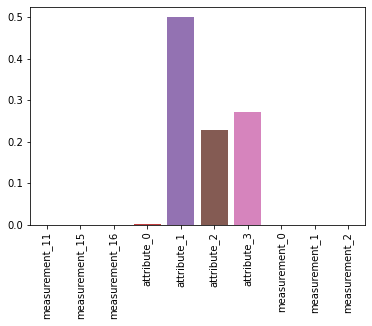

In [32]:
try:
    categorical_cols.remove('product_code')
except ValueError:
    pass

combined_data_no_product_code = combined_data.drop(['product_code'], axis=1)

fit_adversarial_model(combined_data_no_product_code, in_test_dataset, estimator_pipeline = mod_xgb)

Area under ROC curve (cross-validated): 0.89

Variable        Importance
--------------------------
loading         0.01
measurement_3   0.01
measurement_4   0.02
measurement_5   0.02
measurement_6   0.03
measurement_7   0.03
measurement_8   0.02
measurement_9   0.02
measurement_10  0.03
measurement_11  0.04
measurement_12  0.04
measurement_13  0.04
measurement_14  0.04
measurement_15  0.04
measurement_16  0.04
measurement_17  0.03
attribute_0     0.21
measurement_0   0.19
measurement_1   0.05
measurement_2   0.09


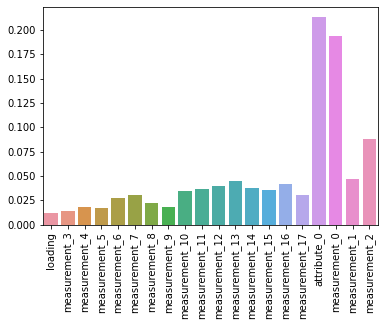

In [33]:
# Since we've already saw this in EDA: `attribute_1`, `attribute_2` and `attribute_3`. Let's drop it
try:
    categorical_cols.remove('attribute_1')
except ValueError:
    pass
combined_data2 = combined_data_no_product_code.drop(['attribute_1', 'attribute_2', 'attribute_3'], axis=1)
fit_adversarial_model(combined_data2, in_test_dataset, estimator_pipeline = mod_xgb)

<iframe src="https://www.kaggle.com/embed/nnjjpp/adversarial-validation-detecting-data-drift?cellIds=23&kernelSessionId=103205636" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Adversarial validation - detecting data drift"></iframe>

Area under ROC curve (cross-validated): 1.00

Variable        Importance
--------------------------
loading         0.01
measurement_3   0.00
measurement_4   0.01
measurement_5   0.02
measurement_6   0.00
measurement_7   0.02
measurement_8   0.01
measurement_9   0.00
measurement_10  0.10
measurement_11  0.19
measurement_12  0.01
measurement_13  0.01
measurement_14  0.10
measurement_15  0.08
measurement_16  0.23
measurement_17  0.02
product_code    14.51
attribute_0     4.70
attribute_1     4.02
attribute_2     3.17
attribute_3     3.05
measurement_0   0.13
measurement_1   0.23
measurement_2   0.01


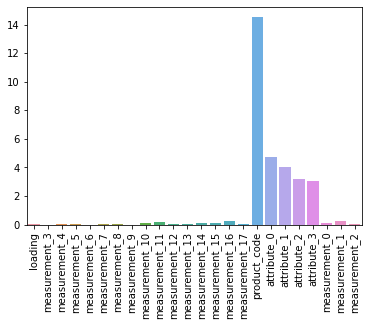

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Set up the pipeline again as we changed the input data (categorical_cols, etc.)
combined_data = combined_data_original.copy()
categorical_cols = categorical_cols_original.copy()
missing_cols = missing_cols_original.copy()
preprocessing = ColumnTransformerNamed([('median_infill', SimpleImputerNamed(strategy='median'), missing_cols),
                                        ('ordinal_encode', OrdinalEncoderNamed(), categorical_cols)],
                                       remainder='passthrough')  
mod_logreg = Pipeline(steps = (['preprocessing', preprocessing],
                               ['scaling', StandardScaler()],
                               ['logistic_regression', LogisticRegression(penalty='l2',
                                                                          solver='saga',
                                                                          class_weight='balanced',
                                                                          max_iter=2000,
                                                                          C=10**6,
                                                                          random_state = 200)]))

fit_adversarial_model(combined_data, np.array(in_test_dataset).ravel(), estimator_pipeline = mod_logreg, plot=True)

<iframe src="https://www.kaggle.com/embed/nnjjpp/adversarial-validation-detecting-data-drift?cellIds=26&kernelSessionId=103205636" height="300" style="margin: 0 auto; width: 100%; max-width: 900px;" frameborder="0" scrolling="auto" title="Adversarial validation - detecting data drift"></iframe>